### Setup and Imports

In [ ]:
!pip install -q xgboost imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier


### Load and Pre process Data


In [5]:
train = pd.read_csv('/content/Training_Cleaned.csv')
test  = pd.read_csv('/content/Testing_Cleaned.csv')

print("Raw train shape:", train.shape)
print("Raw test shape: ", test.shape)
display(train.head())
display(test.head())


Raw train shape: (263, 133)
Raw test shape:  (42, 133)


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction


In [7]:
target = 'prognosis'

# Prepare features and labels
X = train.drop(columns=[target]).astype(int)
y_raw = train[target].astype(str)

X_test = test.drop(columns=[target]).astype(int)
y_test_raw = test[target].astype(str)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_raw)
y_test = le.transform(y_test_raw)

print("Classes (label encoder):", list(le.classes_))
print("X shape:", X.shape, "y shape:", y.shape)


Classes (label encoder): ['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne', 'Alcoholic hepatitis', 'Allergy', 'Arthritis', 'Bronchial Asthma', 'Cervical spondylosis', 'Chicken pox', 'Chronic cholestasis', 'Common Cold', 'Dengue', 'Diabetes ', 'Dimorphic hemmorhoids(piles)', 'Drug Reaction', 'Fungal infection', 'GERD', 'Gastroenteritis', 'Heart attack', 'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E', 'Hypertension ', 'Hyperthyroidism', 'Hypoglycemia', 'Hypothyroidism', 'Impetigo', 'Jaundice', 'Malaria', 'Migraine', 'Osteoarthristis', 'Paralysis (brain hemorrhage)', 'Peptic ulcer diseae', 'Pneumonia', 'Psoriasis', 'Tuberculosis', 'Typhoid', 'Urinary tract infection', 'Varicose veins', 'hepatitis A']
X shape: (263, 132) y shape: (263,)


In [8]:
print("Unique rows in X (post-clean):", X.duplicated().sum(), "duplicates remain")
print("Train class distribution (counts):")
display(pd.Series(y).value_counts().sort_index())
print("Test class distribution (counts):")
display(pd.Series(y_test).value_counts().sort_index())


Unique rows in X (post-clean): 0 duplicates remain
Train class distribution (counts):


,count
0,6
1,4
2,4
3,7
4,4
5,5
6,6
7,5
8,9
9,7


Test class distribution (counts):


,count
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [9]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Internal split: train", X_tr.shape, "val", X_val.shape)


Internal split: train (210, 132) val (53, 132)


### Baseline Model


In [10]:
# Baseline model
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6,
                    subsample=0.8, colsample_bytree=0.8,
                    random_state=42, eval_metric='mlogloss')

xgb.fit(X, y)
y_pred = xgb.predict(X_test)
print("Baseline XGBoost Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Baseline XGBoost Test Accuracy: 0.9761904761904762
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       0.50      1.00      0.67         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold       1.00      1

### Baseline Model Metrics

=== Baseline Model Evaluation ===
Accuracy : 0.9762
Precision: 0.9881
Recall   : 0.9762
F1 Score : 0.9762

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
     

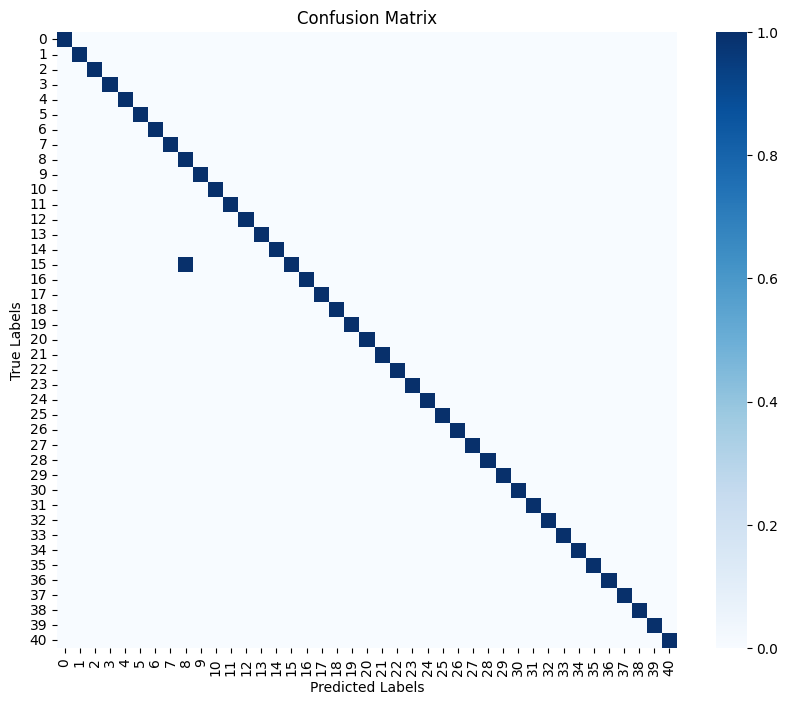

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("=== Baseline Model Evaluation ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Cross Validation

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


CV scores per fold: [0.88679245 0.94339623 0.98113208 0.94230769 0.88461538]
CV mean: 0.9276, std: 0.0370


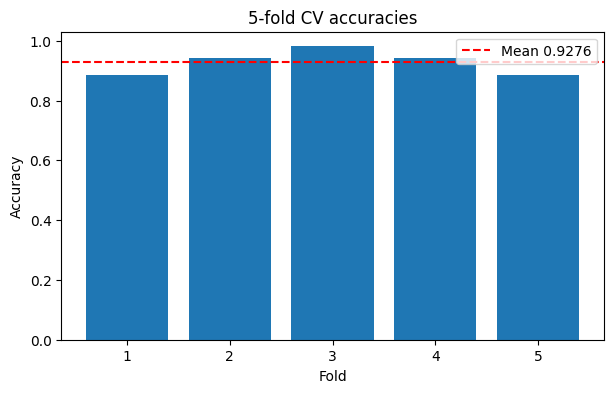

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print("CV scores per fold:", cv_scores)
print("CV mean: {:.4f}, std: {:.4f}".format(cv_scores.mean(), cv_scores.std()))

# Visualize fold scores
plt.figure(figsize=(7,4))
plt.bar(range(1, len(cv_scores)+1), cv_scores)
plt.axhline(cv_scores.mean(), color='r', linestyle='--', label=f'Mean {cv_scores.mean():.4f}')
plt.xlabel('Fold'); plt.ylabel('Accuracy'); plt.title('5-fold CV accuracies'); plt.legend(); plt.show()


### Hyperparameter Tuning


In [13]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

xgb_base = XGBClassifier(random_state=42, eval_metric='mlogloss')
grid = GridSearchCV(xgb_base, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV (grid) score:", grid.best_score_)
best_xgb = grid.best_estimator_


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Best CV (grid) score: 0.8935910832462556


### Tuned Model Metrics


Tuned XGBoost Test Accuracy: 0.9761904761904762
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       0.50      1.00      0.67         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold       1.00      1.00

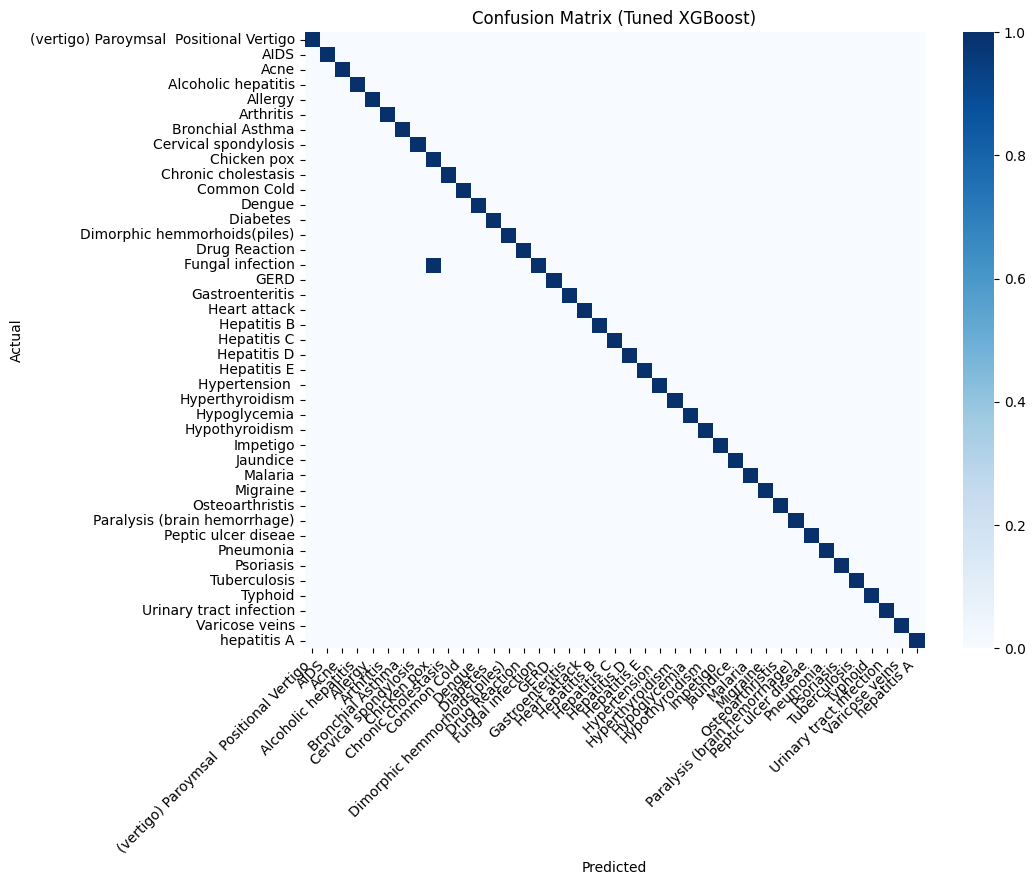

In [14]:
y_pred_best = best_xgb.predict(X_test)
print("Tuned XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Tuned XGBoost)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.show()
